In [124]:
import numpy as np
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
import phate
import pandas as pd
from sklearn.cluster import KMeans

In [125]:
adata = sc.read_h5ad('../data/pseudotime.h5ad')

<Axes: >

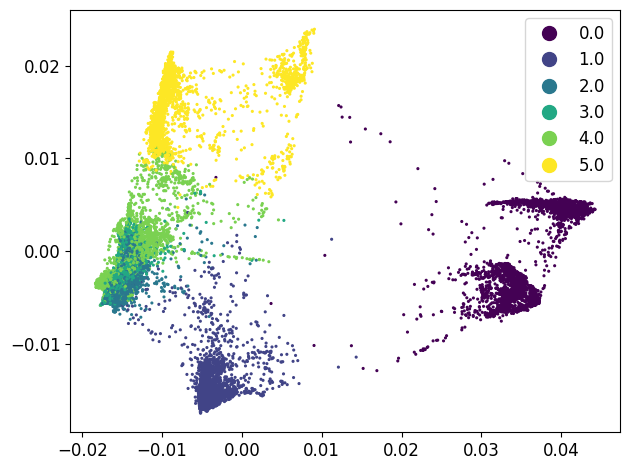

In [126]:
scprep.plot.scatter2d(adata.obsm['X_phate'], adata.obs['bin'], cmap='viridis')

In [127]:
# subsampled_adatas = []
# for t in [0,1,2,3,4]:
#     bin_adata = adata[adata.obs['bin'] == t].copy()
#     bin_subsampled = bin_adata
#     subsampled_adatas.append(bin_subsampled)
# for t in [5]:
#     # Get data for current bin
#     bin_adata = adata[adata.obs['bin'] == t].copy()
    
#     # Cluster the data
#     n_clusters = 3
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bin_adata.obsm['X_phate'])
#     bin_adata.obs['cluster'] = kmeans.labels_
    
#     # Get counts and find second smallest cluster size
#     cluster_counts = pd.Series(kmeans.labels_).value_counts()
#     target_size = cluster_counts.iloc[-1]
    
#     # Subsample each cluster
#     subsampled = []
#     for cluster in range(n_clusters):
#         cluster_data = bin_adata[bin_adata.obs['cluster'] == cluster]
#         if len(cluster_data) > target_size:
#             subsampled.append(cluster_data[np.random.choice(len(cluster_data), target_size, replace=False)])
#         else:
#             subsampled.append(cluster_data)
    
#     # Combine subsampled clusters
#     bin_subsampled = sc.concat(subsampled)
#     subsampled_adatas.append(bin_subsampled)
    
#     # Plot the subsampled data
#     scprep.plot.scatter2d(bin_subsampled.obsm['X_phate'], bin_subsampled.obs['cluster'], cmap='viridis')

# # Combine all bins into one AnnData object
# subsampled_adata = sc.concat(subsampled_adatas)


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0    1494
1    1002
2     333
dtype: int64

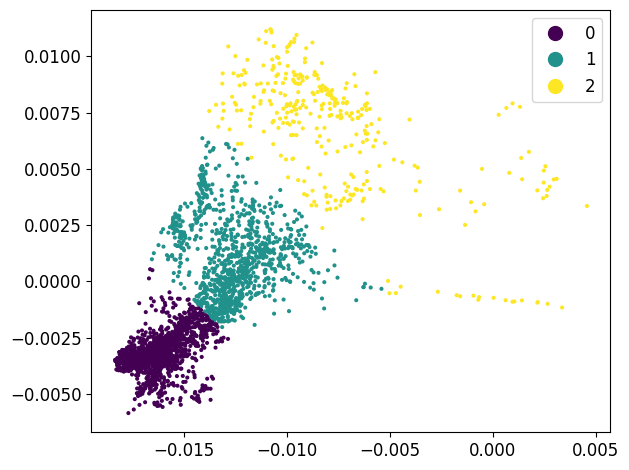

In [128]:
t = 4
bin_subsubsampled_ = adata[adata.obs['bin'] == t].copy()
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bin_subsubsampled_.obsm['X_phate'])
bin_subsubsampled_.obs['cluster'] = kmeans.labels_
scprep.plot.scatter2d(bin_subsubsampled_.obsm['X_phate'], bin_subsubsampled_.obs['cluster'], cmap='viridis')
pd.Series(kmeans.labels_).value_counts()


In [129]:
adata.obs.loc[bin_subsubsampled_.obs_names[bin_subsubsampled_.obs['cluster'] == 2], 'bin'] = 5

<Axes: >

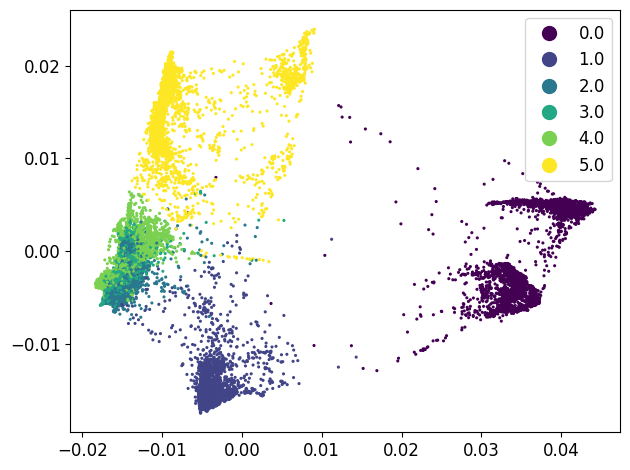

In [130]:
scprep.plot.scatter2d(adata.obsm['X_phate'], adata.obs['bin'], cmap='viridis')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0    1414
2    1274
1     475
dtype: int64


<Axes: >

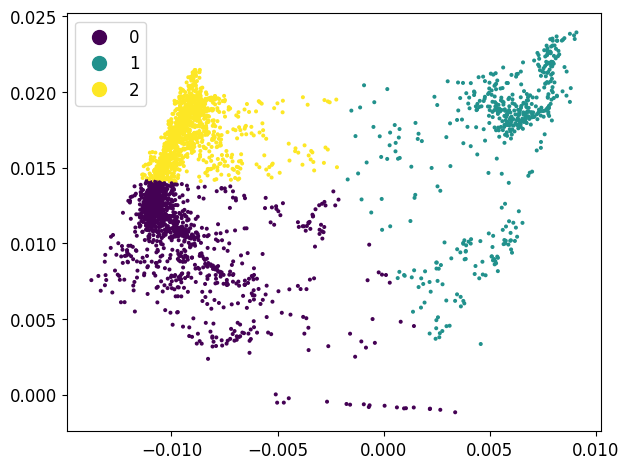

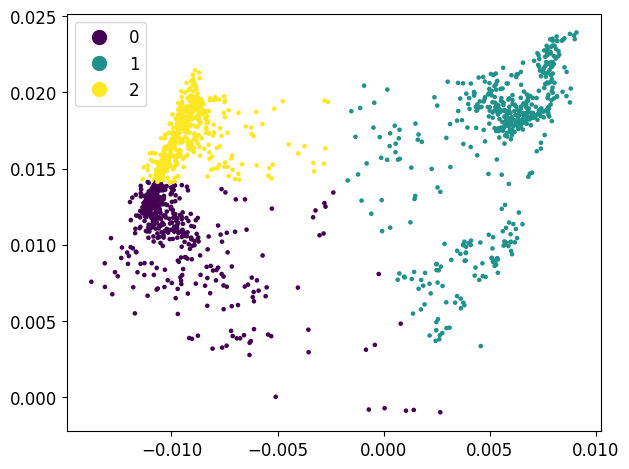

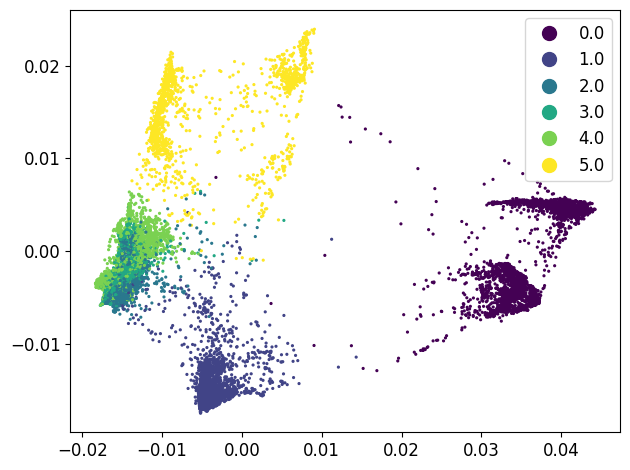

In [131]:
t = 5
bin_adata = adata[adata.obs['bin'] == t].copy()
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bin_adata.obsm['X_phate'])
bin_adata.obs['cluster'] = kmeans.labels_
scprep.plot.scatter2d(bin_adata.obsm['X_phate'], bin_adata.obs['cluster'], cmap='viridis')
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)

# Calculate target size for clusters 0+2 combined
cluster1_size = cluster_counts[1]
target_size_per_cluster = cluster1_size 

# Subsample clusters 0 and 2
subsampled = []
for cluster in [0, 2]:
    cluster_data = bin_adata[bin_adata.obs['cluster'] == cluster]
    subsampled.append(cluster_data[np.random.choice(len(cluster_data), target_size_per_cluster, replace=False)])

# Add cluster 1 without subsampling
subsampled.append(bin_adata[bin_adata.obs['cluster'] == 1])

# Combine subsampled clusters
bin_subsampled = sc.concat(subsampled)

# Plot the subsampled data
scprep.plot.scatter2d(bin_subsampled.obsm['X_phate'], bin_subsampled.obs['cluster'], cmap='viridis')
pd.Series(bin_subsampled.obs['cluster']).value_counts()

# Save the subsampled data for bin 5
subsampled_adata = adata.copy()
subsampled_adata = subsampled_adata[~(subsampled_adata.obs['bin'] == t)].copy() # Remove bin 5
subsampled_adata = sc.concat([subsampled_adata, bin_subsampled]) # Add subsampled bin 5

# Verify the subsampling worked
scprep.plot.scatter2d(subsampled_adata.obsm['X_phate'], subsampled_adata.obs['bin'], cmap='viridis')


In [132]:
bin_dict = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 3,
}
subsampled_adata.obs['bin_merged'] = subsampled_adata.obs['bin'].map(bin_dict)

<Axes: >

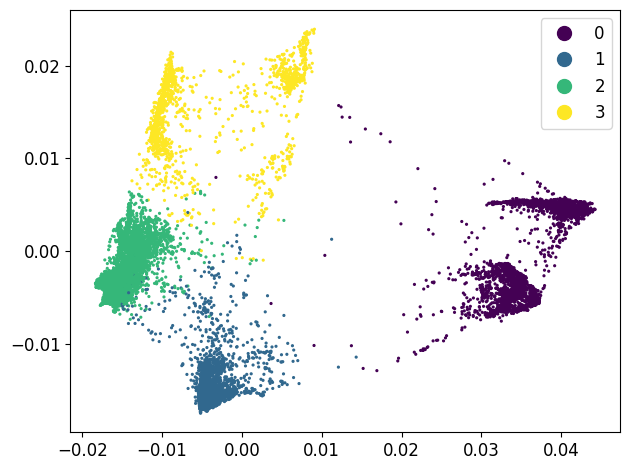

In [133]:
scprep.plot.scatter2d(subsampled_adata.obsm['X_phate'], subsampled_adata.obs['bin_merged'], cmap='viridis')

In [134]:
subsampled_adata.write('../data/balanced_subsampled.h5ad')

In [135]:
mioflow_df = pd.DataFrame(subsampled_adata.obsm['X_phate'], columns=['d1', 'd2'], index=subsampled_adata.obs.index)
mioflow_df['samples'] = subsampled_adata.obs['bin_merged'].values
# Create a new empty DataFrame to store the subsampled data
subsampled_df = pd.DataFrame()

# Subsample each bin to exactly 500 points
n_samples_per_bin = 1000
for bin in range(4):
    bin_df = mioflow_df[mioflow_df['samples'] == bin]
    if len(bin_df) >= n_samples_per_bin:
        sampled = bin_df.sample(n_samples_per_bin, random_state=42)
        subsampled_df = pd.concat([subsampled_df, sampled])
    else:
        subsampled_df = pd.concat([subsampled_df, bin_df])
# Save the balanced dataset
subsampled_df.to_csv('../data/mioflow_balanced_subsampled.csv')

# Verify the counts
print(subsampled_df['samples'].value_counts())

0    1000
1    1000
2    1000
3    1000
Name: samples, dtype: int64


<Axes: xlabel='d1', ylabel='d2'>

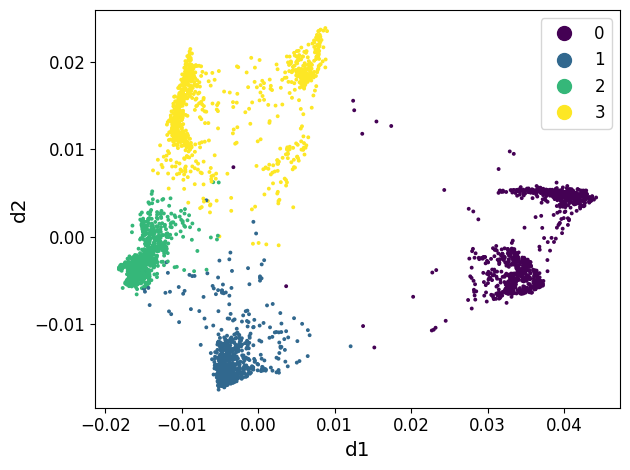

In [136]:
scprep.plot.scatter2d(subsampled_df[['d1', 'd2']], subsampled_df['samples'], cmap='viridis')
